In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
header = [np.array(['partitioning', 'cfg', 'univmon', 'univmon', 'univmon_greedy', 
                    'univmon_greedy', 'univmon_greedy_rows', 'univmon_greedy_rows', 
                    'netmon', 'netmon']), 
         np.array(['', '', 'throughput', 'resources', 'throughput', 'resources', 
                   'throughput', 'resources', 'throughput', 'resources'])]
df = pd.read_csv("../outputs/sensitivity.csv")

In [3]:
df = df.drop(df.columns[-1], axis=1)
df.columns = header

In [4]:
df

partitioning cfg    univmon           univmon_greedy            \
                    throughput resources     throughput resources   
0             v   1     70.000    83.382         70.000    83.382   
1             v   2     56.000    85.006         56.000    85.007   
2             v   3          -         -         93.333   655.640   
3             v   4     80.000    70.647         93.333    63.035   
4             v   5     56.000   113.197         56.000   113.197   
5             v   6     35.000    95.006         35.000    95.006   
6             v   7     87.500   168.800         35.000   107.013   
7             v   8    148.000     2.874        148.000     2.874   
8             v   9          -         -         87.500   703.396   
9            hv   0     93.333    70.428         93.333    60.856   
10           hv   1     80.000    83.887         80.000    83.878   
11           hv   2     56.000    85.057         56.000    85.007   
12           hv   3          -         -         93.333   655.640   
13           hv   4     80.000    70.647         93.333    63.035   
14           hv   5     56.000   113.217         87.500   154.946   
15           hv   6     35.000   105.058         78.619   156.256   
16           hv   7     56.000   137.802         70.000   167.750   
17           hv   8    148.000     2.874        148.000     2.874   
18           hv   9          -         -         87.500   703.396   
19            h   0     93.333    70.571         93.333    60.856   
20            h   1     80.000    74.246         80.000    74.246   
21            h   2     56.000    73.111         56.000    73.111   
22            h   3          -         -         80.000   575.904   
23            h   4     80.000    70.855         93.333    63.035   
24            h   5     87.500   133.017         56.000   101.244   
25            h   6     70.000   104.884         42.271   103.111   
26            h   7     70.000   125.126         35.000    83.171   
27            h   8    148.000     2.874        148.000     2.874   
28            h   9          -         -         75.791   699.674   
29            n   0     87.500    70.001         93.333    60.856   
30            n   1     80.000    74.246         80.000    74.246   
31            n   2     56.000    73.111         56.000    73.111   
32            n   3          -         -         80.000   575.904   
33            n   4     79.732    61.281         93.333    63.035   
34            n   5     74.679   113.017         70.000   121.244   
35            n   6     53.328    94.884         56.000   113.111   
36            n   7     53.328   105.126         56.000   123.171   
37            n   8    148.000     2.874        148.000     2.874   
38            n   9          -         -         75.791   699.674   
39            v   3          -         -         87.500   655.900   
40            v   9          -         -         80.000   703.448   
41            v   3          -         -         87.500   654.872   
42            v   9          -         -         80.000   703.447   
43            v   3          -         -         87.500   655.899   
44            v   9          -         -         80.000   703.428   

   univmon_greedy_rows               netmon            
            throughput resources throughput resources  
0               80.000    74.124     76.694    69.730  
1               56.000    85.007     56.000    73.111  
2               93.333   655.650     88.880   615.876  
3               93.333    63.035     93.333    63.035  
4               87.500   154.946     83.325   132.788  
5               87.500   156.756     83.325   144.872  
6               87.500   168.748     83.325   154.970  
7              148.000     2.874    148.000     2.874  
8               87.500   703.396     83.325   673.347  
9               93.333    60.856     93.333    60.856  
10              80.000    74.126     76.694    69.730  
11              56.000    85.00

In [5]:
df = df.replace(' -', np.nan)

In [6]:
df['univmon'] = df['univmon'].astype('float')

In [7]:
df.describe()

cfg     univmon             univmon_greedy              \
                  throughput   resources     throughput   resources   
count  45.000000   31.000000   31.000000      45.000000   45.000000   
mean    4.800000   79.168806   81.842129      80.721533  263.636311   
std     2.912356   31.001100   39.374545      27.325400  277.785887   
min     0.000000   35.000000    2.874000      35.000000    2.874000   
25%     3.000000   56.000000   70.609000      56.000000   73.111000   
50%     5.000000   79.732000   83.382000      80.000000  103.111000   
75%     7.000000   87.500000  105.092000      93.333000  654.872000   
max     9.000000  148.000000  168.800000     148.000000  703.448000   

      univmon_greedy_rows                  netmon              
               throughput   resources  throughput   resources  
count           45.000000   45.000000   45.000000   45.000000  
mean            86.657311  268.168489   85.346578  255.158422  
std             22.647477  275.540026   22.589489  261.825902  
min             56.000000    2.874000   56.000000    2.874000  
25%             80.000000   73.111000   76.183000   69.730000  
50%             87.500000  114.627000   83.325000  124.884000  
75%             93.333000  654.872000   88.880000  575.907000  
max            148.000000  703.448000  148.000000  699.674000

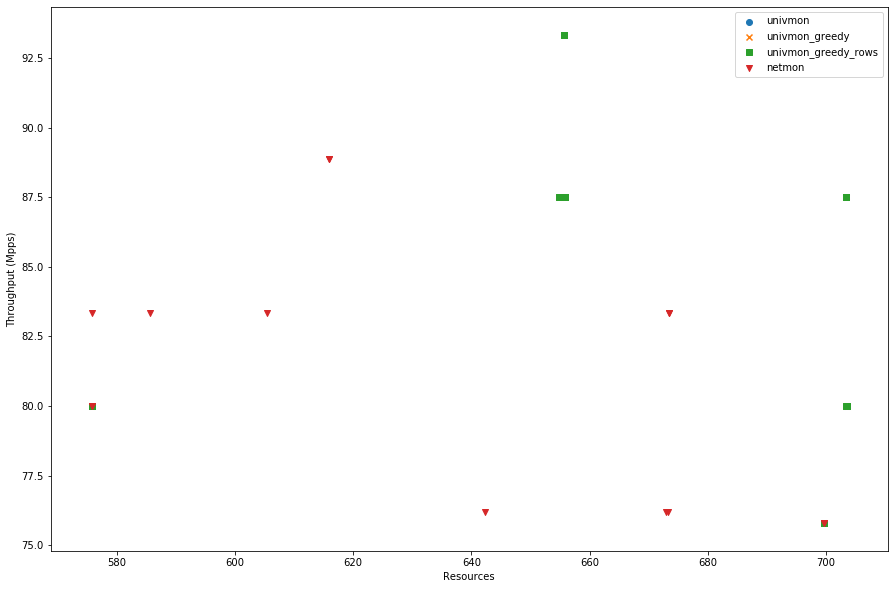

In [8]:
solvers = ['univmon', 'univmon_greedy', 'univmon_greedy_rows', 'netmon']
selection = [3, 9]
markers = ['o', 'x', 's', 'v']
plt.figure(figsize=(15, 10))
idx = 0
for solver in solvers:
    plt.scatter(df[solver]['resources'][df['cfg'].isin(selection)], 
                df[solver]['throughput'][df['cfg'].isin(selection)],
                label=solver, marker=markers[idx])
    idx += 1

plt.legend()
plt.ylabel('Throughput (Mpps)')
plt.xlabel('Resources')
plt.show()

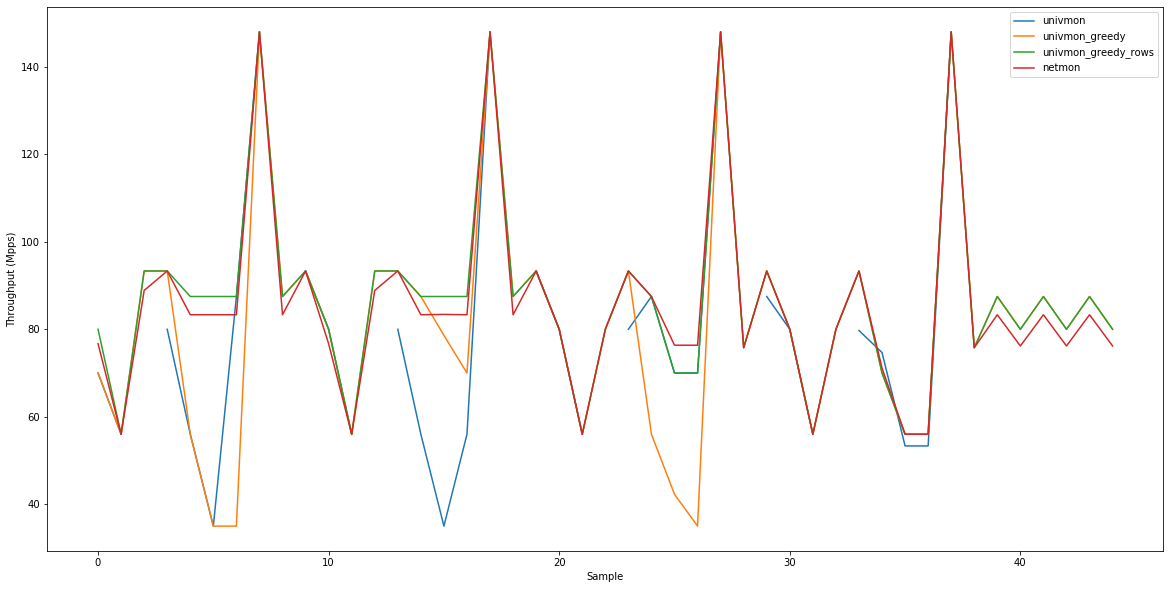

In [9]:
plt.figure(figsize=(20, 10))
for solver in solvers:
    plt.plot(df.index, df[solver]['throughput'], label=solver)

plt.ylabel('Throughput (Mpps)')
plt.xlabel('Sample')
plt.legend()
plt.show()

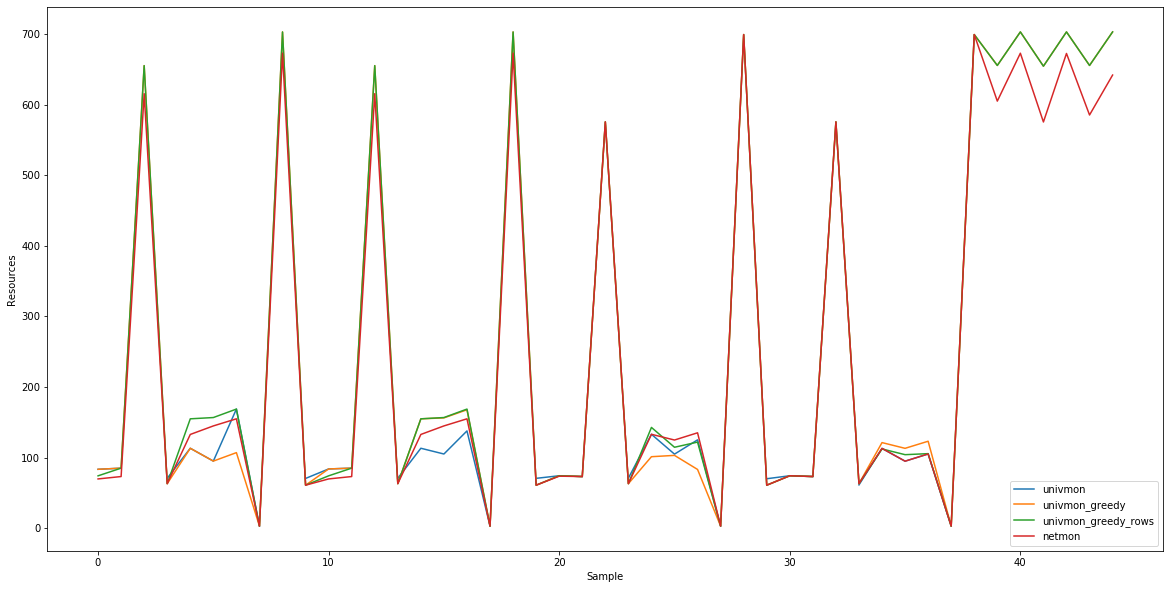

In [10]:
plt.figure(figsize=(20, 10))
for solver in solvers:
    plt.plot(df.index, df[solver]['resources'], label=solver)

plt.ylabel('Resources')
plt.xlabel('Sample')
plt.legend()
plt.show()

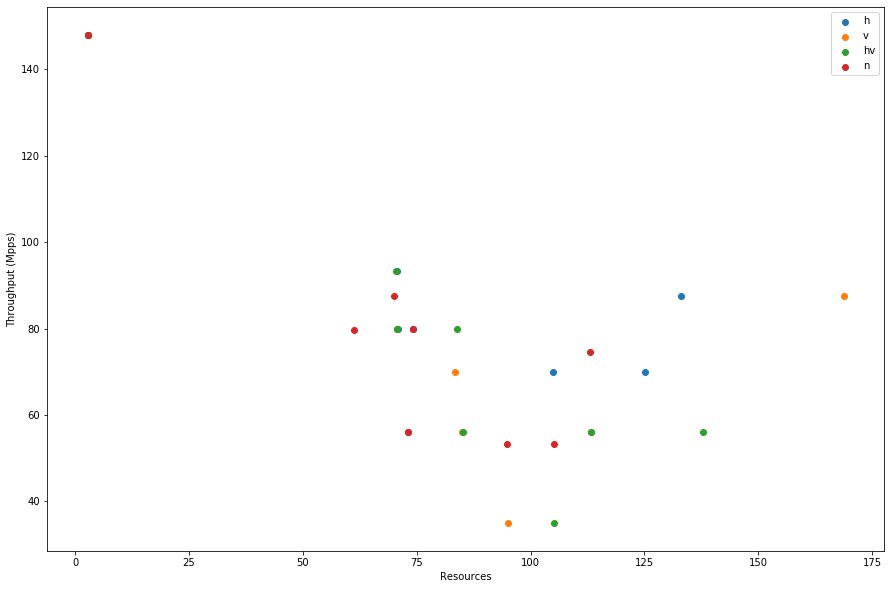

In [11]:
pars = ['h', 'v', 'hv', 'n']
plt.figure(figsize=(15, 10))
for par in pars:
    ys = df['univmon']['throughput'][df['partitioning'] == par]
    for solver in solvers[1:]:
        ys.append(df[solver]['throughput'][df['partitioning'] == par])
        
    xs = df['univmon']['resources'][df['partitioning'] == par]
    for solver in solvers[1:]:
        ys.append(df[solver]['resources'][df['partitioning'] == par])
    
    plt.scatter(xs, ys, label=par)
    
plt.ylabel('Throughput (Mpps)')
plt.xlabel('Resources')
plt.legend()
plt.show()